In [1]:
import pandas as pd
import numpy as np
import torch
import sys

sys.path.insert(0, '../../../src/')
from utils.script_utils import create_parser, create_data_
sys.path.insert(0, '../../../scripts/')
from softmargin_run_new import add_arg_parser

In [17]:
seeds = np.arange(0,100).tolist()
num_conf = [1]*len(seeds)
num_conf = dict(zip(range(len(num_conf)), num_conf))

parser = create_parser()
add_arg_parser(parser)
args = parser.parse_args("")
args.type_graph="i_bird"

args.N = 330
args.d = 10
args.h = 3
args.t_limit = 14 # Numbers of epoch of our epidemics spreading [0,1,...,T_limit-1]
args.lambda_ = 0.5 # probability of infection
args.gamma = 2e-4 # probability of infection
args.mu = 0.02 # probability of recovery
args.small_lambda_limit=300
args.p_edge = 1
args.scale=2
args.a_min=0.01
args.a_max=0.22
args.a_step=0.01
args.path_contacts="i_bird_contacts.npz"
nsims=[int(1e6), 10_000_000, 100_000_000]
nsims_str = ["10000000", "100000000"]
path_dir = "./data"
if path_dir == "not_setted":
    path_dir = type_graph

In [4]:
%%capture
from epigen.epidemy_gen import epidemy_gen_new

list_contacts = {}
data_={}
INSTANCES = []
for i_seed, seed in enumerate(seeds):
    print(f"\nSEED: {seed}")
    
    args.seed=seed
    args.num_conf=num_conf[i_seed]
    #print(args)
    temp, name_file, INSTANCE = create_data_(args, give_instance=True)
    INSTANCES.append(INSTANCE)
    #Ns[cl] = int(max(temp["contacts"][:, 1]) + 1)
    list_contacts[seed] = temp["contacts"]
    data_[seed] = temp
N=args.N
data_.keys()

# READ DATA

create name_files

In [18]:
name_files_nn = {}
Ns = [args.N]
args.d=10
for i_seed, seed in enumerate(seeds):
    #print(f"\nSEED: {seed}")
    name_files_nn[seed] = {}
    name_file_init = path_dir + "/ann/"
    #print(step, name_file_init)
    name_file_temp = name_file_init + f"N_{N}_d_{args.d}_h_{args.h}_T_{args.t_limit}_lam_{args.lambda_}_mu_{args.mu}_p_edge_{args.p_edge}"
    name_file_temp += f"_s_{seed}"
    name_files_nn[seed] = name_file_temp

name_files_nn2 = {}
for i_seed, seed in enumerate(seeds):
    #print(f"\nSEED: {seed}")
    name_files_nn2[seed] = {}
    name_file_init = path_dir + "/ann/"
    #print(step, name_file_init)
    name_file_temp = name_file_init + str(INSTANCES[i_seed])
    name_file_temp = name_file_temp.replace("d_3", "d_10")
    name_files_nn2[seed] = name_file_temp


name_files_sib = {}
for i_seed, seed in enumerate(seeds):
    #print(f"\nSEED: {seed}")
    name_files_sib[seed] = {}
    name_file_init = path_dir + "/sib/"
    #print(step, name_file_init)
    name_file_temp = name_file_init + f"N_{N}_d_{args.d}_h_{args.h}_T_{args.t_limit}_lam_{args.lambda_}_mu_{args.mu}_p_edge_{args.p_edge}"
    name_file_temp += f"_s_{seed}"
    name_files_sib[seed] = name_file_temp
            #print(name_file_temp)
        
name_files_sm = {}
for i_sim, nsim in enumerate(nsims):
    name_files_sm[nsim]={}
    for i_seed, seed in enumerate(seeds):
        #print(f"\nSEED: {seed}")
        name_files_sm[nsim][seed] = {}
        name_file = path_dir + "/sm_good/" + str(INSTANCES[i_seed])
        name_file += f"_nc_{num_conf[seed]}"
        #name_file+= f"_softm_nsims_{nsim}_nit_{args.n_iter}"
        name_file+= f"_softm_nsims_{nsim}_rep_0"
        #print(name_file)
        name_files_sm[nsim][seed] = name_file


### READ FILES

In [6]:
#create dictorary containing data
ress = {}
for i_seed, seed in enumerate(seeds):
    #print(f"SEED: {seed}")
    ress[seed] = {}
    ress[seed] = []
    for instance_num in range(num_conf[i_seed]):
        #print(f" N: {N_cl} instance {instance_num}")
        ress[seed].append({})


In [6]:
name_files_nn2[seed] +"_" + str(instance_num)

'./data/ann/i_bird_n_330_d_10_tlim_14_lam_0.5_mu_0.02_s_99_pe_1_0'

In [8]:
for i_seed, seed in enumerate(seeds):
    print(f" {seed}", end="")
    for instance_num in range(num_conf[i_seed]):
        ress[seed][instance_num]["regressive"] = {}
        #print(f"Read instance {instance_num}")
        name_temp = name_files_nn[seed] +"_" + str(instance_num)
        try:
            name_temp = name_files_nn2[seed] +"_" + str(instance_num)
            ress[seed][instance_num]["regressive"] = {}
            ress[seed][instance_num]["regressive"]["marginals"] = np.load(name_temp + "_margs.npz",
                                                                    "r+",
                                                                   allow_pickle=True,
                                                                   fix_imports=True)["marginals"]
        except:
            print("new not found. try next")
            name_temp = name_files_nn[seed] +"_" + str(instance_num)
            ress[seed][instance_num]["regressive"] = {}
            ress[seed][instance_num]["regressive"]["marginals"] = np.load(name_temp + "_margs.npz",
                                                                    "r+",
                                                                   allow_pickle=True,
                                                                   fix_imports=True)["marginals"]
        try:
            ress[seed][instance_num]["regressive"]["run"] = pd.read_csv(name_temp + ".gz")
            beta = ress[seed][instance_num]["regressive"]["run"]["beta"].iloc[-1]
            if beta < 1:
                print(f"***** beta {beta} {seed}")
            #print(f"  instance_num: {instance_num}")
        except:
            print("no gz")
        try:
            '''ress[seed][N_cl][instance_num]["regressive"]["net"] = torch.load(name_temp + ".pt",
                                                                  map_location=device)
            #ress[N_cl][instance_num]["regressive"]["net"].to(device)
            ress[seed][N_cl][instance_num]["regressive"]["net"].device = device
            for ll in ress[seed][N_cl][instance_num]["regressive"]["net"].sublayers:
                for l in ll:
                    l.device=device
            print(f"  NN net: {instance_num}")'''
            pass
        except:
            print(f"  NN net: {instance_num} NON FOUND")

 0new not found. try next
 1new not found. try next
 2new not found. try next
 3new not found. try next
 4new not found. try next
 5new not found. try next
 6new not found. try next
 7new not found. try next
 8new not found. try next
 9new not found. try next
 10new not found. try next
 11new not found. try next
 12new not found. try next
 13new not found. try next
 14new not found. try next
 15new not found. try next
 16new not found. try next
 17new not found. try next
 18new not found. try next
 19new not found. try next
 20new not found. try next
 21new not found. try next
 22new not found. try next
 23new not found. try next
 24new not found. try next
 25new not found. try next
 26new not found. try next
 27 28 29new not found. try next
 30new not found. try next
 31 32new not found. try next
 33new not found. try next
 34new not found. try next
 35new not found. try next
 36new not found. try next
 37new not found. try next
 38new not found. try next
 39new not found. try next
 4

In [9]:
for i_seed, seed in enumerate(seeds):
    print(f" {seed}", end="")
    for instance_num in range(num_conf[i_seed]):
        #print(f"Read instance {instance_num}")
        name_temp = name_files_sib[seed] +"_" + str(instance_num)
        ress[seed][instance_num]["sib"] = {}
        try:
            ress[seed][instance_num]["sib"]["marginals"] = np.load(name_temp + "_sib_margs.npz",
                                                                    "r+",
                                                                   allow_pickle=True,
                                                                   fix_imports=True)["marginals"]
            #print("load SIB")
        except:
            print(f"SIB not found")


 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

In [19]:
for i_seed, seed in enumerate(seeds):
    print(f" {seed}", end="")
    for instance_num in range(num_conf[i_seed]):
        ress[seed][instance_num]["sm"] = {}
        for nsim in nsims:
            ress[seed][instance_num]["sm"][nsim] = {}
            #print(f"Read instance {instance_num}, nsim: {nsim}")
            #for nsim in nsims:
            name_temp_sm = name_files_sm[nsim][seed]
            ffname=name_temp_sm + "_probs.npz"
            try:
                    #ress[seed][N_cl][instance_num]["sm"][nsim] = {}
                '''ress[seed][N_cl][instance_num]["sm"][nsim]["marginals"] = np.load(name_temp_sm + "_margs.npz",
                                                                                "r+",
                                                                               allow_pickle=True,
                                                                               fix_imports=True)["margs_0"]'''
                ress[seed][instance_num]["sm"][nsim]["prob_zero"] = np.load(ffname,
                                                                                "r+",
                                                                               allow_pickle=True,
                                                                               fix_imports=True)["inst_" + str(instance_num)]
                #print(f"loaded SF nsim: {instance_num} ...")
            except FileNotFoundError:
                print(f"not found SF {ffname} ")

                    #ress[instance_num]["regressive"]["net"] = torch.load(name_temp + ".pt")                          name_temp = name_files_nn[seed][N_cl][step] +"_" + str(instance_num)


 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

# results

In [12]:
from analysis.results_analysis import sources_finder, plot_patient_zero_roc

In [13]:
import analysis.results_analysis
import imp
imp.reload(analysis.results_analysis)
from analysis.results_analysis import sources_finder, plot_patient_zero_roc

In [21]:
marginals, pos_sources = sources_finder(ress, data_, num_conf, nsims)

In [22]:
import pickle
with open("pos_sources.pkl", "wb") as f:
    pickle.dump( pos_sources, f )

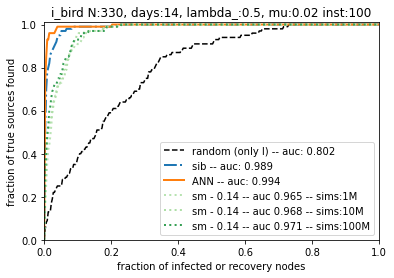

In [31]:
import matplotlib.pyplot as plt
bins=N
plot_patient_zero_roc(plt,
                          pos_sources, 
                          nsims, 
                      args,
                          alpha=13, 
                          bins=bins,
                          range_=(0,1),
                          norm=N,
                          colors=plt.get_cmap("Greens"))
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1.01)
plt.title(f"{args.type_graph} N:{Ns[0]}, days:{args.t_limit}, lambda_:{args.lambda_}, mu:{args.mu} inst:{100}")
plt.xlabel("fraction of infected or recovery nodes")
plt.ylabel("fraction of true sources found")
#plt.ylim(0,17)
plt.show()

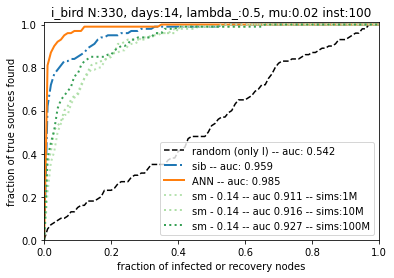

In [30]:
import matplotlib.pyplot as plt
bins=100
plot_patient_zero_roc(plt,
                          pos_sources, 
                          nsims, 
                          args,
                          alpha=13, 
                          bins=bins,
                          range_=(0,1),
                          norm=pos_sources["Is_len"],
                          colors=plt.get_cmap("Greens"))
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1.01)
plt.title(f"{args.type_graph} N:{Ns[0]}, days:{args.t_limit}, lambda_:{args.lambda_}, mu:{args.mu} inst:{100}")
plt.xlabel("fraction of infected or recovery nodes")
plt.ylabel("fraction of true sources found")
#plt.ylim(0,17)
plt.show()

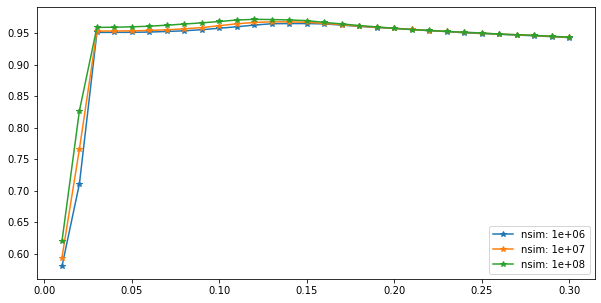

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
plt.figure(figsize=(10,5))
norm=N
bins=N
range_=(0,1)
for nsim in nsims:
    alphas = []
    y = []
    for alpha in range(len(pos_sources["sm"][0][nsim])):
        pos_source_sm=np.array([pos_sources["sm"][ii][nsim][alpha] for ii in range(len(pos_sources["sm"]))])
        s_sm,x = np.histogram(pos_source_sm/norm, bins=bins, range=range_)
        y_sm = np.insert(np.cumsum(s_sm)/len(pos_sources["sm"]),0,0)        
        #print(alpha, np.cumsum(s_sm))
        #plt.plot(x, y_sm, label=f"sm - {a_min+alpha*a_step:.2f} -- auc {auc(x, y_sm):.3f} -- sims:{nsim}")
        y.append(auc(x, y_sm))
        alphas.append(args.a_min+alpha*args.a_step)
    plt.plot(alphas, y, "*-",label=f"nsim: {nsim:.0e}")
plt.legend()
#plt.xlim(0,1)
#plt.title(f"work95 N:{Ns[0]}, days:{t_limit}, gamma:{gamma[0]}, mu:{mu} inst:{len(true_sources[0])}")
#plt.ylim(0,17)

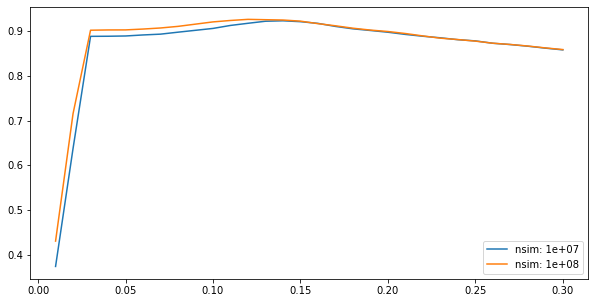

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
plt.figure(figsize=(10,5))
norm=pos_sources["Is_len"]
bins=100
range_=(0,1)
for nsim in nsims:
    alphas = []
    y = []
    for alpha in range(len(pos_sources["sm"][0][nsim])):
        pos_source_sm=np.array([pos_sources["sm"][ii][nsim][alpha] for ii in range(len(pos_sources["sm"]))])
        s_sm,x = np.histogram(pos_source_sm/norm, bins=bins, range=range_)
        y_sm = np.insert(np.cumsum(s_sm)/len(pos_sources["sm"]),0,0)        
        #print(alpha, np.cumsum(s_sm))
        #plt.plot(x, y_sm, label=f"sm - {a_min+alpha*a_step:.2f} -- auc {auc(x, y_sm):.3f} -- sims:{nsim}")
        y.append(auc(x, y_sm))
        alphas.append(args.a_min+alpha*args.a_step)
    plt.plot(alphas, y, label=f"nsim: {nsim:.0e}")
plt.legend()
#plt.xlim(0,1)
#plt.title(f"work95 N:{Ns[0]}, days:{t_limit}, gamma:{gamma[0]}, mu:{mu} inst:{len(true_sources[0])}")
#plt.ylim(0,17)

In [18]:
count=0
for i in seeds:
    for instance in range(len(data_[i]["epidemy"])):
        I = (data_[i]["epidemy"][instance][0][0] < np.inf).sum()
        steps = ress[i][instance]["regressive"]["run"]["step"].iloc[-1]
        print(i, pos_sources["regressive"][count], pos_sources["sib"][count], I, steps)
        count += 1

0 0 13 99 10098
1 0 0 230 10098
2 0 0 259 10098
3 0 2 82 10098
4 0 0 86 10098
5 0 0 209 10098
6 0 1 13 10098
7 0 0 155 10098
8 0 0 118 10098
9 1 27 83 10098
10 2 9 17 10098
11 0 0 124 10098
12 11 8 134 10098
13 0 0 182 10098
14 1 0 92 10098
15 0 0 2 10098
16 0 0 154 10098
17 0 1 138 10098
18 0 0 189 10098
19 0 0 238 10098
20 0 4 236 10098
21 0 2 163 10098
22 0 1 170 10098
23 0 0 2 10098
24 0 0 141 10098
25 0 0 150 10098
26 0 0 241 10098
27 0 0 200 20098.0
28 1 5 244 20098.0
29 0 1 80 10098
30 0 0 89 10098
31 2 2 242 20098.0
32 1 1 179 10098
33 0 0 58 10098
34 2 12 99 10098
35 0 3 60 10098
36 4 2 129 10098
37 1 1 23 10098
38 0 0 2 10098
39 0 0 167 10098
40 0 2 93 10098
41 0 0 169 10098
42 0 0 5 10098
43 0 0 185 10098
44 4 1 58 10098
45 0 0 189 20098.0
46 1 0 251 10098
47 0 0 51 10098
48 0 0 70 10098
49 0 71 248 10098
50 0 0 2 10098
51 1 1 80 10098
52 0 0 146 10098
53 0 1 10 10098
54 0 0 190 10098
55 0 0 219 10098
56 0 0 39 10098
57 0 0 99 10098
58 0 10 45 10098
59 0 2 8 10098
60 0 0 173

In [19]:
for i in range(len(pos_sources["regressive"])):
    I = (data_[i]["epidemy"][0][0][0] < np.inf).sum()
    print(i, pos_sources["regressive"][i], pos_sources["sib"][i], I)


0 0 13 99
1 0 0 230
2 0 0 259
3 0 2 82
4 0 0 86
5 0 0 209
6 0 1 13
7 0 0 155
8 0 0 118
9 1 27 83
10 2 9 17
11 0 0 124
12 11 8 134
13 0 0 182
14 1 0 92
15 0 0 2
16 0 0 154
17 0 1 138
18 0 0 189
19 0 0 238
20 0 4 236
21 0 2 163
22 0 1 170
23 0 0 2
24 0 0 141
25 0 0 150
26 0 0 241
27 0 0 200
28 1 5 244
29 0 1 80
30 0 0 89
31 2 2 242
32 1 1 179
33 0 0 58
34 2 12 99
35 0 3 60
36 4 2 129
37 1 1 23
38 0 0 2
39 0 0 167
40 0 2 93
41 0 0 169
42 0 0 5
43 0 0 185
44 4 1 58
45 0 0 189
46 1 0 251
47 0 0 51
48 0 0 70
49 0 71 248
50 0 0 2
51 1 1 80
52 0 0 146
53 0 1 10
54 0 0 190
55 0 0 219
56 0 0 39
57 0 0 99
58 0 10 45
59 0 2 8
60 0 0 173
61 2 12 73
62 0 0 4
63 0 0 117
64 0 1 41
65 1 1 136
66 1 4 254
67 1 1 218
68 0 0 239
69 0 0 191
70 2 1 192
71 0 0 179
72 0 0 243
73 2 2 102
74 0 7 44
75 10 11 86
76 66 21 189
77 0 0 102
78 0 0 157
79 0 0 178
80 0 0 203
81 0 1 124
82 0 0 220
83 0 1 26
84 0 3 157
85 0 0 195
86 0 1 98
87 0 0 204
88 2 16 87
89 12 1 232
90 0 0 2
91 4 5 116
92 1 2 54
93 0 6 65
94 0 16 10